### 0.import library and set configration

In [1]:
import os
import pandas as pd
import numpy as np
import scipy as sp
from scipy.stats import norm
# グラフをインラインで表示させる
import matplotlib.pyplot as plt
import japanize_matplotlib #日本語化matplotlib
%matplotlib inline

import seaborn as sns
sns.set(font="IPAexGothic") #日本語フォント設定

from ydata_profiling import ProfileReport

import warnings
# 全ての警告を無視する
warnings.filterwarnings("ignore")

c:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#機械学習用のライブラリインストール
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import optuna
import shap


In [3]:
import geopandas as gpd


In [4]:
#import_original_function
from function.data_processing import test2
from function.data_processing import addtional_process
from function.modeling import objective

In [5]:
#pandasの表示設定
# 表示制限の緩和
pd.set_option('display.max_columns', 300 )
pd.set_option('display.max_rows', 500 )
# 指数表記の無効化
pd.options.display.float_format = '{:.2f}'.format

In [6]:
#configファイルの読み込み
import configparser
config_ini = configparser.ConfigParser()
config_ini.read('./config/config.ini', encoding='utf-8')

['./config/config.ini']

In [7]:
#read_file_congfig
test_file = config_ini["INPUT_FILE"]["test"]
train_file = config_ini["INPUT_FILE"]["train"]
deginition_file = config_ini["CONFIG_FILE"]["deginition"]
submit_file = config_ini["OUTPUT_FILE"]["submit"]
shap_plot_file = config_ini["OUTPUT_FILE"]["shap_plot"]
#read_var_config
response_var = config_ini["VAR"]["response_var"]
#read_other_info
version = config_ini["VERSION"]["version"]


In [28]:
#make_output_folder
ouput_folder_path  = f"./output/ver{version}/"
os.makedirs(ouput_folder_path, exist_ok=True) 

### 1.import_train/test_data


In [9]:
#データの成型方法を読込
df_deginition  = pd.read_excel(deginition_file,index_col=0, dtype = 'object')
df_deginition  = df_deginition.query('採否 == "◎"|採否 == "〇"| 採否 == "△"')

#学習に使うカラムを選択
target_columns = df_deginition["本番データ特徴量名"].values.tolist()

# #ダミー変数化するカラムを選択
# dummy_columns = df_deginition.query("ダミー変数化 == '〇'")["本番データ特徴量名"].values.tolist()


In [10]:
# 対象のCSVデータの読込
df_train_raw = pd.read_csv(train_file , header=0,sep=',' , dtype = 'object')
df_test_raw  = pd.read_csv(test_file  , header=0,sep=',' , dtype = 'object')

In [11]:
# shp_path = "./input/国土数値情報データ/人口推移/500m_mesh_2018_14.shp"
# gdf_population = gpd.read_file(shp_path, encoding='cp932')  # Shapefile読込

### 2.data_processing

#### 2-1.select_varriables

In [12]:
# 対象カラムを絞り込み
df_train = df_train_raw[target_columns]
df_test = df_test_raw[[col for col in target_columns if not col == response_var]]

# 抽出結果を表示
display(df_train.head(2))
display(df_test.head(2))

,money_room,building_status,building_type,unit_count,building_structure,floor_count,year_built,room_floor,dwelling_unit_window_angle,room_count,unit_area,bukken_type,post1,post2,addr1_1,addr1_2,walk_distance1,walk_distance2,flg_new,room_kaisuu,snapshot_window_angle,madori_number_all,madori_kind_all,parking_kubun,genkyo_code,convenience_distance,super_distance
0,38000,1,3,22,1,2,200210,2,5,1,23.1800003,3102,598,44,27,213,1040,NaN,0,2,5,1,20,1,3,239,1280
1,103000,1,1,NaN,4,3,197612,1,5,2,47.7000008,3101,173,36,13,119,320,400,0,1,5,2,30,3,2,399,434


,building_status,building_type,unit_count,building_structure,floor_count,year_built,room_floor,dwelling_unit_window_angle,room_count,unit_area,bukken_type,post1,post2,addr1_1,addr1_2,walk_distance1,walk_distance2,flg_new,room_kaisuu,snapshot_window_angle,madori_number_all,madori_kind_all,parking_kubun,genkyo_code,convenience_distance,super_distance
0,1,3,6,10,2,201101,2,6,2,62.5099983,3102,756,57,35,216,160,NaN,0,2,5,2,50,1,2,NaN,NaN
1,1,1,15,4,3,198703,3,5,1,19.4400005,3101,182,7,13,208,240,800,0,3,5,1,20,4,3,190,30


#### 2-2.replace data_type and NA

In [13]:
#前処理（データ型変換、補完）

# 欠損個所をNAという文字列で置換
df_train = df_train.fillna("NA")
df_test = df_test.fillna("NA")

for idx ,raw  in df_deginition.iterrows():
    #データの変換対象、変換方法を確認
    col = raw["本番データ特徴量名"]
    complement_value = raw["欠損補完方法"]
    type = raw["データ型"]

    #補完値が空でなければ補完
    if complement_value != np.nan : 
        try:
            df_train[col] = df_train[col].replace("NA",complement_value)
        except Exception as e:
            print("補完",col,complement_value,type)
            print(f"エラーが発生しました: {e}")
        try:
            df_test[col] = df_test[col].replace("NA",complement_value)
        except Exception as e:
            print("補完",col,complement_value,type)
            print(f"エラーが発生しました: {e}")

    #データ型変換
    try:
        df_train[col] = df_train[col].astype(type)
    except Exception as e:
        print("置換",col,complement_value,type)
        print(f"エラーが発生しました: {e}")
    try:
        df_test[col]  = df_test[col].astype(type)
    except Exception as e:
        print("置換",col,complement_value,type)
        print(f"エラーが発生しました: {e}")



補完 money_room 0 int
エラーが発生しました: 'money_room'
置換 money_room 0 int
エラーが発生しました: 'money_room'


#### 2-3.additional_processing

In [14]:
#特殊前処理
df_train = addtional_process(df_train)
df_test  = addtional_process(df_test)

In [15]:
#train_dataのみ追加処理

# 東京都（addr1_1=13）以外の100万円以上のデータを中央値の52000円で置換
df_train.loc[(df_train['addr1_1'] != '13') & (df_train['money_room'] >= 1000000), 'money_room'] = df_train['money_room'].median()

df_train["unit_area"] = df_train["unit_area"].fillna(0)
df_train["unit_area"] = df_train["unit_area"].astype(type)

# # df_train['unit_area']が300以上、df_train['money_room']が50万円以下の物件を中央値で置換
df_train.loc[(df_train['unit_area'] >= 300) & (df_train['money_room'] < 500000), 'unit_area'] = df_train['unit_area'].median()

# year_builtが70以上の物件を、year_builtの中央値で置換
df_train.loc[df_train['year_built'] > 70, 'year_built'] = df_train['year_built'].median()

# floor_countが70以上の物件を、floor_countの中央値で置換
df_train.loc[df_train['floor_count'] > 64, 'floor_count'] = df_train['floor_count'].median()


In [16]:
#データの水増し
price_th = 500000
low_price_data = df_train.query(f"money_room <{price_th}")
high_price_data = df_train.query(f"money_room >={price_th}")
data_count_rate = len(low_price_data)/len(high_price_data) #低価格データが高価格データの何倍存在しているかの比率
data_count_rate = int(data_count_rate)
print("低価格物件数：",len(low_price_data))
print("高価格物件数：",len(high_price_data))
print("比率：",data_count_rate)

低価格物件数： 584272
高価格物件数： 235
比率： 2486


In [17]:
expanded_low_price_data = pd.concat([high_price_data] * data_count_rate, ignore_index=True)
expanded_low_price_data

,money_room,building_status,building_type,unit_count,building_structure,floor_count,year_built,room_floor,dwelling_unit_window_angle,room_count,unit_area,bukken_type,post1,post2,addr1_1,addr1_2,walk_distance1,walk_distance2,flg_new,room_kaisuu,snapshot_window_angle,madori_number_all,madori_kind_all,parking_kubun,genkyo_code,convenience_distance,super_distance
0,1350000,1,1,195,5,32,23,15,5,3,186.49,3101,106,32,13,103,80,480,0,15,5,3,50,1,1,413.25,641.52
1,1100000,1,1,147,5,19,54,11,0,1,0.00,3101,108,73,13,103,560,800,0,11,7,4,50,1,2,430.00,690.00
2,1000000,1,1,147,5,19,54,10,2,4,246.36,3101,108,73,13,103,720,800,0,10,2,4,50,1,2,347.00,706.00
3,580000,1,1,18,4,5,8,3,3,3,77.87,3101,108,73,13,103,480,880,0,3,3,3,50,1,2,413.25,641.52
4,500000,1,1,6,4,3,37,3,5,3,162.86,3101,602,8003,26,102,720,1920,0,3,5,3,50,4,2,363.00,698.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584205,780000,1,1,92,5,8,25,5,8,3,119.79,3101,106,31,13,103,640,960,0,5,8,3,55,1,1,413.25,641.52
584206,594000,1,1,92,5,8,25,2,4,2,89.16,3101,106,31,13,103,640,1040,0,2,3,2,50,1,2,413.25,641.52
584207,1200000,1,1,1,4,5,8,2,6,2,154.49,3101,106,32,13,103,320,320,0,2,6,2,55,1,2,335.00,336.00
584208,550000,1,1,33,4,12,8,12,5,3,90.24,3101,108,71,13,103,80,80,0,12,4,3,50,4,3,413.25,641.52


In [18]:
df_train  = pd.concat([df_train,expanded_low_price_data],ignore_index=True)
df_train

,money_room,building_status,building_type,unit_count,building_structure,floor_count,year_built,room_floor,dwelling_unit_window_angle,room_count,unit_area,bukken_type,post1,post2,addr1_1,addr1_2,walk_distance1,walk_distance2,flg_new,room_kaisuu,snapshot_window_angle,madori_number_all,madori_kind_all,parking_kubun,genkyo_code,convenience_distance,super_distance
0,38000,1,3,22,1,2,23,2,5,1,23.18,3102,598,44,27,213,1040,9999,0,2,5,1,20,1,3,239.00,1280.00
1,103000,1,1,1,4,3,49,1,5,2,47.70,3101,173,36,13,119,320,400,0,1,5,2,30,3,2,399.00,434.00
2,50000,1,3,1,1,3,29,2,3,2,46.35,3102,65,21,01,103,880,1120,0,2,3,2,50,1,2,201.00,741.00
3,37000,1,3,1,3,2,32,1,6,2,39.74,3102,720,92,34,207,700,700,0,1,6,2,30,1,2,413.25,1114.00
4,33000,1,3,1,3,2,32,2,6,2,39.74,3102,720,92,34,207,2012,3532,0,2,7,2,30,1,2,413.25,641.52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1168712,780000,1,1,92,5,8,25,5,8,3,119.79,3101,106,31,13,103,640,960,0,5,8,3,55,1,1,413.25,641.52
1168713,594000,1,1,92,5,8,25,2,4,2,89.16,3101,106,31,13,103,640,1040,0,2,3,2,50,1,2,413.25,641.52
1168714,1200000,1,1,1,4,5,8,2,6,2,154.49,3101,106,32,13,103,320,320,0,2,6,2,55,1,2,335.00,336.00
1168715,550000,1,1,33,4,12,8,12,5,3,90.24,3101,108,71,13,103,80,80,0,12,4,3,50,4,3,413.25,641.52


#### 2-4.validation

In [19]:
# 予測対象のデータを学習用と評価用に分割（バリデーション）
df_x = df_train.loc[:, df_train.columns!= response_var]
# df_x = pd.get_dummies(data = df_x,columns=dummy_columns, dtype='int')
df_x = pd.get_dummies(data = df_x, dtype='int')

df_y = df_train[response_var]

# 学習用：評価用が70%：30%
df_x_train, df_x_test, df_y_train, df_y_test = train_test_split(df_x, df_y, test_size=0.3, random_state=0)

### 3.modeling

In [20]:
# Optunaによるハイパーパラメータの最適化
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, df_x_train, df_y_train, df_x_test, df_y_test), 
               n_trials=100)
print(f"最適なパラメータ: {study.best_params}")

# 最適なパラメータを使用して最終モデルのトレーニング
best_params = study.best_params
best_params['objective'] = 'regression'
best_params['metric'] = 'rmse'

model = lgb.train(best_params, 
                    lgb.Dataset(df_x_train, label=df_y_train), 
                    valid_sets=[lgb.Dataset(df_x_test, label=df_y_test)])


最適なパラメータ: {'learning_rate': 0.08573961717517849, 'num_leaves': 100, 'min_data_in_leaf': 10, 'feature_fraction': 0.6642461241239085, 'bagging_fraction': 0.8904440323414212, 'bagging_freq': 1}


In [29]:
#modelの出力
import pickle
pickle.dump(model, open(ouput_folder_path+'model.pkl', 'wb'))


### 4.evaluation

In [33]:
#モデルの読み込み
model = pickle.load(open(ouput_folder_path+'model.pkl', 'rb'))

In [34]:
#テストデータの予測結果
y_pred = model.predict(df_x_test, num_iteration=model.best_iteration)
rmse = mean_squared_error(df_y_test, y_pred, squared=False)

#トレーニングデータの予測結果
y_pred_train = model.predict(df_x_train, num_iteration=model.best_iteration)
rmse_train = mean_squared_error(df_y_train, y_pred_train, squared=False)

# 予実の比較
print(f"RMSE（predict_train）: {rmse}")
print(f"RMSE（test_train）: {rmse_train}")


RMSE（predict_train）: 10026.063819194283
RMSE（test_train）: 9257.102505904546


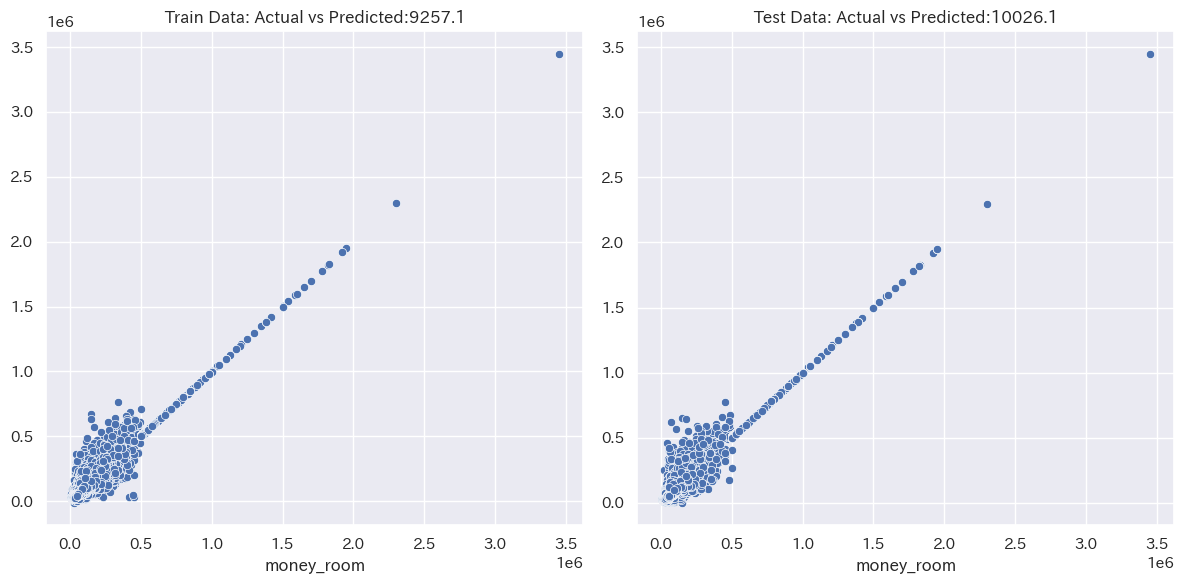

In [32]:
"""
💡trainデータの予測精度が異常に良い場合はオーバーフィッティングの可能性がある💡
"""
# 2つの散布図を横並びに表示するために、matplotlib の subplots を使う
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1行2列のサブプロット

# サブプロット1: トレーニングデータの散布図
sns.scatterplot(x=df_y_train, y=y_pred_train, ax=axes[0])
axes[0].set_title(f'Train Data: Actual vs Predicted:{round(rmse_train,1)}')  # タイトルを追加
# サブプロット1: テストデータの散布図
sns.scatterplot(x=df_y_test, y=y_pred, ax=axes[1])
axes[1].set_title(f'Test Data: Actual vs Predicted:{round(rmse,1)}')  # タイトルを追加

# レイアウト調整
plt.tight_layout()

# 画像として保存
plt.savefig(ouput_folder_path+"predict_result.jpg", format="jpg", dpi=300)

# プロットを表示
plt.show()


In [24]:
#notebook内でJavascriptを動かすためのおまじない
shap.initjs()
#TreeExplainerは、決定木系のモデルのSHAP値を取得するもの。
X_test_shap = df_x_test.copy().reset_index(drop=True)
explainer = shap.TreeExplainer(model=model)
shap_values = explainer.shap_values(X=X_test_shap)
#base_shap_valueに対して、各変数のshapスコア×変数の値を掛け合わせた値が予測値になる。
print("base_shap_value",explainer.expected_value)


base_shap_value 436989.6663026888


In [ ]:
ouput_folder_path

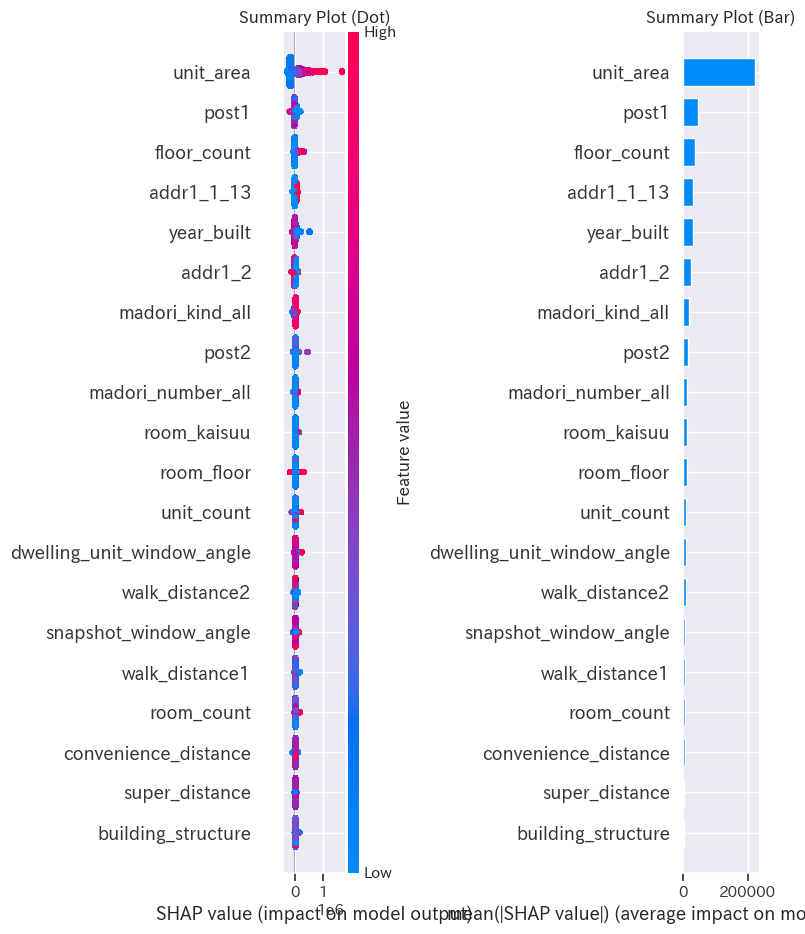

In [25]:
# サブプロットの作成（正方形に設定）
fig, axes = plt.subplots(1, 2, figsize=(10, 10))  # 1行2列のサブプロット、正方形

# 左側の図: summary_plot
plt.sca(axes[0])  # 左側のサブプロットをアクティブに
shap.summary_plot(shap_values, X_test_shap, plot_type='dot', show=False)
axes[0].set_title("Summary Plot (Dot)", fontsize=12)

# 右側の図: bar plot
plt.sca(axes[1])  # 右側のサブプロットをアクティブに
shap.summary_plot(shap_values, X_test_shap, plot_type='bar', show=False)
axes[1].set_title("Summary Plot (Bar)", fontsize=12)

# レイアウト調整
plt.tight_layout()

# 画像として保存
plt.savefig(ouput_folder_path+shap_plot_file, format="jpg", dpi=300)

# プロットを表示
plt.show()


#### 5.create submit.csv

In [26]:
#submit

# 評価用データで賃料を予測
df_test_model_x = df_test
df_test_model_x = pd.get_dummies(df_test_model_x, dtype='int')

y_pred = model.predict(df_test_model_x)

# y_predからデータフレームを作成
pred_df = pd.DataFrame(y_pred, columns=['money_room'])

# pred_dfをCSV出力、ヘッダーなし
pred_df.to_csv(ouput_folder_path + submit_file, index=True, header=False)

# 予測値を確認
display(pred_df.head())

,money_room
0,62879.34
1,51948.36
2,59813.12
3,48446.48
4,107441.93
